# Uplift Modeling for Churn Prediction — EDA and Feature Engineering


## 1. Setup


In [ ]:
# Setup may take 30–60s: utils imports sentence_transformers, causalml, lightgbm, xgboost.
from pathlib import Path
import importlib
import pandas as pd
from sentence_transformers import SentenceTransformer

import utils
importlib.reload(utils)  # use latest utils.py (re-run this cell after editing utils)
from utils import (  # noqa: E402 — must be after reload() to get latest code
    build_member_aggregates, count_events_before_signup, embed_wellco_brief, 
    EMBED_MODEL_NAME, engineer_member_aggregates, load_wellco_brief, 
    MEMBER_AGG_FEATURE_COLS, missingness_and_member_coverage,
    missingness_mechanism_aggregated_table, plot_balance, plot_correlation_diagnostics, 
    plot_variable_distributions, plot_bivariate_churn_grid, print_table_overview, ref_date_from_tables, 
    verify_member_aggregates, 
)

pd.set_option('display.max_columns', 200)
# Project root (parent of src/); files/ is at project root, not inside src
BASE_DIR = Path('.').resolve().parent
FILE_DIR = BASE_DIR / 'files'  # all data files live under files/
TRAIN_DIR = FILE_DIR / 'train'
TEST_DIR = FILE_DIR / 'test'

## 2. Load data
Train/test CSVs; train events restricted to observation window (July 1–15, 2025).

In [3]:
# Training data
churn_labels = pd.read_csv(TRAIN_DIR / "churn_labels.csv", parse_dates=["signup_date"])
app_usage = pd.read_csv(TRAIN_DIR / "app_usage.csv", parse_dates=["timestamp"])
web_visits = pd.read_csv(TRAIN_DIR / "web_visits.csv", parse_dates=["timestamp"])
claims = pd.read_csv(TRAIN_DIR / "claims.csv", parse_dates=["diagnosis_date"])

# Test data
test_members = pd.read_csv(TEST_DIR / "test_members.csv", parse_dates=["signup_date"])
test_app_usage = pd.read_csv(TEST_DIR / "test_app_usage.csv", parse_dates=["timestamp"])
test_web_visits = pd.read_csv(TEST_DIR / "test_web_visits.csv", parse_dates=["timestamp"])
test_claims = pd.read_csv(TEST_DIR / "test_claims.csv", parse_dates=["diagnosis_date"])

# Observation window: July 1 - July 15, 2025 (pre-outreach). Outreach = July 15; churn measured after.
# Restrict train event data only; test data is not filtered (outreach has not occurred for test).
OBS_START = pd.Timestamp("2025-07-01")
OBS_END   = pd.Timestamp("2025-07-15")  # exclusive: keep events strictly before outreach

web_visits = web_visits[(web_visits["timestamp"] >= OBS_START) & (web_visits["timestamp"] < OBS_END)]
app_usage  = app_usage[(app_usage["timestamp"] >= OBS_START) & (app_usage["timestamp"] < OBS_END)]
claims     = claims[(claims["diagnosis_date"] >= OBS_START) & (claims["diagnosis_date"] < OBS_END)]

# Quick sanity check
for name, df in {
    "churn_labels": churn_labels,
    "app_usage": app_usage,
    "web_visits": web_visits,
    "claims": claims,
    "test_members": test_members,
    "test_app_usage": test_app_usage,
    "test_web_visits": test_web_visits,
    "test_claims": test_claims,
}.items():
    print(f"{name}: {df.shape}")

churn_labels: (10000, 4)
app_usage: (97789, 3)
web_visits: (259340, 5)
claims: (64576, 3)
test_members: (10000, 2)
test_app_usage: (97961, 3)
test_web_visits: (261729, 5)
test_claims: (64803, 3)


## **3. EDA**

Exploratory data analysis: table structure, missingness, treatment balance, leakage checks, and churn rate by engagement/claims/recency.

---

### 3.1 Raw data overview
Summarize structure, dtypes, and sample rows for all 8 tables.


In [4]:
all_tables = {
    "churn_labels": churn_labels,
    "app_usage": app_usage,
    "web_visits": web_visits,
    "claims": claims,
    "test_members": test_members,
    "test_app_usage": test_app_usage,
    "test_web_visits": test_web_visits,
    "test_claims": test_claims,
}

for name, df in all_tables.items():
    print_table_overview(name, df)


  churn_labels

--- dtypes ---
member_id               int64
signup_date    datetime64[ns]
churn                   int64
outreach                int64

--- describe (numeric columns only) ---
              churn      outreach
count  10000.000000  10000.000000
mean       0.202100      0.398400
std        0.401587      0.489593
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        0.000000      1.000000
max        1.000000      1.000000

--- date ranges ---
  signup_date: 2024-01-01 00:00:00 to 2025-05-31 00:00:00

--- head(2) ---


,member_id,signup_date,churn,outreach
0,1,2024-04-12,0,0
1,2,2025-03-11,0,0



  app_usage

--- dtypes ---
member_id              int64
event_type            object
timestamp     datetime64[ns]

--- date ranges ---
  timestamp: 2025-07-01 00:00:00 to 2025-07-14 23:59:51

--- object columns (unique counts) ---
  event_type: 1 unique values

--- head(2) ---


,member_id,event_type,timestamp
0,1,session,2025-07-13 08:43:37
1,1,session,2025-07-14 15:28:58



  web_visits

--- dtypes ---
member_id               int64
url                    object
title                  object
description            object
timestamp      datetime64[ns]

--- date ranges ---
  timestamp: 2025-07-01 00:00:01 to 2025-07-14 23:59:49

--- object columns (unique counts) ---
  url: 69894 unique values
  title: 26 unique values
  description: 26 unique values

--- head(2) ---


,member_id,url,title,description,timestamp
0,1,https://health.wellco/chronic/859,Diabetes management,Blood sugar and glycemic control,2025-07-02 22:38:22
1,1,https://portal.site/tech/328,Gadget roundup,Smartphones and laptops news,2025-07-02 11:30:47



  claims

--- dtypes ---
member_id                  int64
icd_code                  object
diagnosis_date    datetime64[ns]

--- date ranges ---
  diagnosis_date: 2025-07-01 00:00:00 to 2025-07-14 00:00:00

--- object columns (unique counts) ---
  icd_code: 10 unique values

--- head(2) ---


,member_id,icd_code,diagnosis_date
0,1,Z71.3,2025-07-09
1,1,Z71.3,2025-07-14



  test_members

--- dtypes ---
member_id               int64
signup_date    datetime64[ns]

--- date ranges ---
  signup_date: 2024-01-01 00:00:00 to 2025-05-31 00:00:00

--- head(2) ---


,member_id,signup_date
0,20001,2024-11-16
1,20002,2024-09-12



  test_app_usage

--- dtypes ---
member_id              int64
event_type            object
timestamp     datetime64[ns]

--- date ranges ---
  timestamp: 2025-07-01 00:00:14 to 2025-07-14 23:59:56

--- object columns (unique counts) ---
  event_type: 1 unique values

--- head(2) ---


,member_id,event_type,timestamp
0,20001,session,2025-07-05 07:03:13
1,20001,session,2025-07-05 20:10:22



  test_web_visits

--- dtypes ---
member_id               int64
url                    object
title                  object
description            object
timestamp      datetime64[ns]

--- date ranges ---
  timestamp: 2025-07-01 00:00:00 to 2025-07-14 23:59:47

--- object columns (unique counts) ---
  url: 69982 unique values
  title: 26 unique values
  description: 26 unique values

--- head(2) ---


,member_id,url,title,description,timestamp
0,20001,https://care.portal/fitness/812,Exercise routines,Cardio and strength workouts,2025-07-09 18:30:35
1,20001,https://media.hub/sports/478,Match highlights,League standings and transfers,2025-07-04 05:25:38



  test_claims

--- dtypes ---
member_id                  int64
icd_code                  object
diagnosis_date    datetime64[ns]

--- date ranges ---
  diagnosis_date: 2025-07-01 00:00:00 to 2025-07-14 00:00:00

--- object columns (unique counts) ---
  icd_code: 10 unique values

--- head(2) ---


,member_id,icd_code,diagnosis_date
0,20001,E11.9,2025-07-06
1,20001,H10.9,2025-07-14


### 3.2 Column-specific checks
event_type, url, title, icd_code for feature-engineering decisions.


In [ ]:
# ----------
# 3.1 Column-specific checks
# Purpose: Check special columns (event_type, url, title, icd_code) for feature engineering decisions.
# What is tested: value_counts for event_type, url, title, icd_code.
# What to do with this info:
#   - If event_type is constant -> drop it.
#   - URL/title variety -> potential content-categorization features.
#   - ICD distribution -> guides focus-ICD flag design.
# ----------

print("="*60)
print("  Column-specific checks")
print("="*60)
print("\napp_usage event_type value_counts:")
print(app_usage["event_type"].value_counts().to_string())
print(f"  -> {'CONSTANT — can drop' if app_usage['event_type'].nunique() == 1 else 'MULTIPLE VALUES — keep'}")

# url and title in web_visits: content variety
print(f"\nweb_visits url: {web_visits['url'].nunique()} unique values")
print("  Top-5 URLs:")
print(web_visits["url"].value_counts().head(5).to_string())
print(f"\nweb_visits title: {web_visits['title'].nunique()} unique values")
print("  Top-5 titles:")
print(web_visits["title"].value_counts().head(5).to_string())

# icd_code in claims
print(f"\nclaims icd_code: {claims['icd_code'].nunique()} unique values")
print("  Top-10 ICD codes:")
print(claims["icd_code"].value_counts().head(10).to_string())

  Column-specific checks

app_usage event_type value_counts:
event_type
session    97789
  -> CONSTANT — can drop

web_visits url: 69894 unique values
  Top-5 URLs:
url
https://portal.site/gaming/682    18
https://example.com/gaming/283    18
https://media.hub/movies/434      18
https://media.hub/cars/275        18
https://world.news/sports/764     17

web_visits title: 26 unique values
  Top-5 titles:
title
Top destinations     22600
Gadget roundup       22553
Electric vehicles    22395
New releases         22271
Match highlights     22257

claims icd_code: 10 unique values
  Top-10 ICD codes:
icd_code
Z71.3    9145
I10      9006
E11.9    8961
H10.9    5414
B34.9    5410
A09      5387
M54.5    5385
J00      5346
R51      5277
K21.9    5245


The most popular URLs are not related to health 

### 3.3 Missing values and member coverage

  Part A — Column-level null check

✓ No null values found in any column of any table.

  Part B — Member coverage across sources

--- TRAIN (base members: 10000) ---
    source  members_present  members_absent  absent_pct
web_visits             9975              25        0.25
 app_usage             9998               2        0.02
    claims             9980              20        0.20

Cross-source missingness patterns (train):
  missing web only: 25 (0.25%)
  missing app only: 2 (0.02%)
  missing claims only: 20 (0.20%)
  missing web+app: 0 (0.00%)
  missing web+claims: 0 (0.00%)
  missing app+claims: 0 (0.00%)
  missing all 3: 0 (0.00%)
  present in all: 9953 (99.53%)


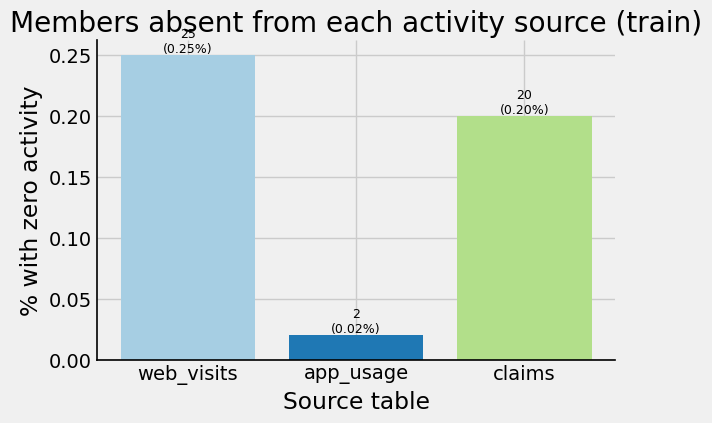


--- TEST (base members: 10000) ---
    source  members_present  members_absent  absent_pct
web_visits             9981              19        0.19
 app_usage             9998               2        0.02
    claims             9978              22        0.22


In [6]:
# 3.2 Missing values and member coverage (utils: missingness_and_member_coverage)
missingness_and_member_coverage(all_tables, churn_labels, web_visits, app_usage, claims, test_members, test_web_visits, test_app_usage, test_claims)

### 3.4 Labels & treatment balance

Overall churn rate: 0.202
Outreach rate: 0.398

Outreach x Churn cross-tabulation:
churn        0     1  Total
outreach                   
0         4768  1248   6016
1         3211   773   3984
Total     7979  2021  10000

Churn rates by group:
          members  churn_rate
outreach                     
0            6016    0.207447
1            3984    0.194026


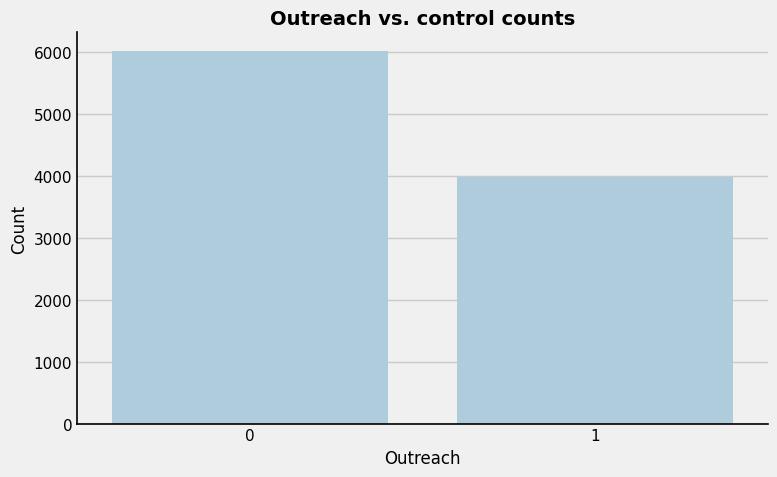

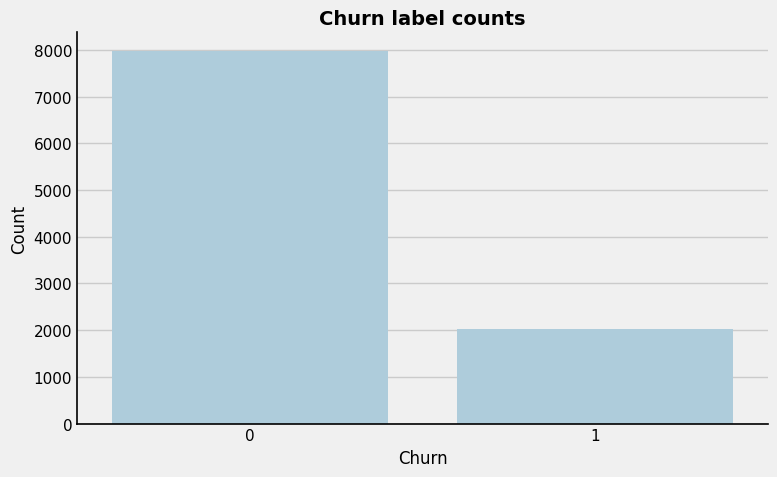

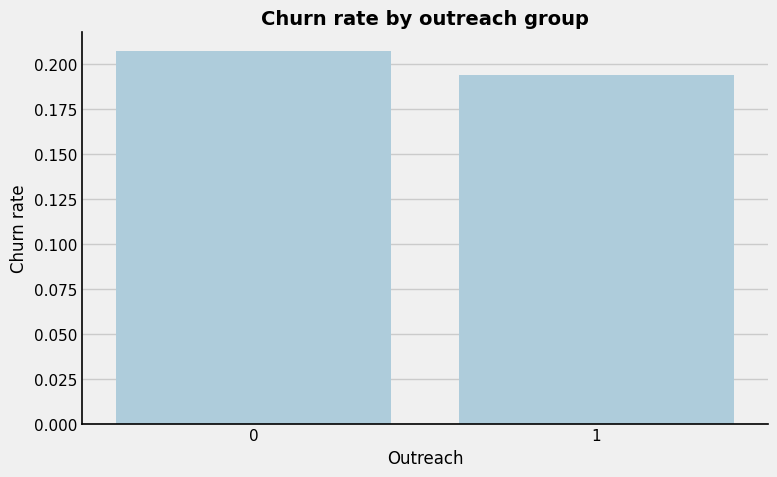

In [7]:
# 3.4 Labels and treatment balance
churn_rate = churn_labels["churn"].mean()
outreach_rate = churn_labels["outreach"].mean()

summary_labels = churn_labels.groupby("outreach")["churn"].agg([
    ("members", "count"),
    ("churn_rate", "mean"),
])

print(f"Overall churn rate: {churn_rate:.3f}")
print(f"Outreach rate: {outreach_rate:.3f}")
print("\nOutreach x Churn cross-tabulation:")
cross_tab = pd.crosstab(churn_labels["outreach"], churn_labels["churn"],
                        margins=True, margins_name="Total")
print(cross_tab.to_string())
print("\nChurn rates by group:")
print(summary_labels.to_string())

plot_balance(churn_labels, "outreach", "Outreach vs. control counts", "Outreach", "Count")
plot_balance(churn_labels, "churn", "Churn label counts", "Churn", "Count")
plot_balance(summary_labels.reset_index(), "outreach", "Churn rate by outreach group", "Outreach", "Churn rate", y="churn_rate")

There is an imbalance between groups.

### 3.5 Leakage & time-window validation

In [8]:
window_summary = pd.DataFrame([
    {'table': 'web_visits', 'min': web_visits['timestamp'].min(), 'max': web_visits['timestamp'].max()},
    {'table': 'app_usage', 'min': app_usage['timestamp'].min(), 'max': app_usage['timestamp'].max()},
    {'table': 'claims', 'min': claims['diagnosis_date'].min(), 'max': claims['diagnosis_date'].max()},
])
leakage = pd.DataFrame([
    {'table': 'web_visits', 'events_before_signup': count_events_before_signup(web_visits, 'timestamp', churn_labels)},
    {'table': 'app_usage', 'events_before_signup': count_events_before_signup(app_usage, 'timestamp', churn_labels)},
    {'table': 'claims', 'events_before_signup': count_events_before_signup(claims, 'diagnosis_date', churn_labels)},
])
display(window_summary)
display(leakage)

,table,min,max
0,web_visits,2025-07-01 00:00:01,2025-07-14 23:59:49
1,app_usage,2025-07-01 00:00:00,2025-07-14 23:59:51
2,claims,2025-07-01 00:00:00,2025-07-14 00:00:00


,table,events_before_signup
0,web_visits,0
1,app_usage,0
2,claims,0


### 3.6 Variable distributions

Inspecting the **distribution of each variable**: kernel density for numerical/continuous variables and bar plots for categorical variables. Category names are shown **vertically on the x-axis** for readability. High-cardinality columns (e.g. `url`) are summarized by **top N categories + Other** so the x-axis stays interpretable.

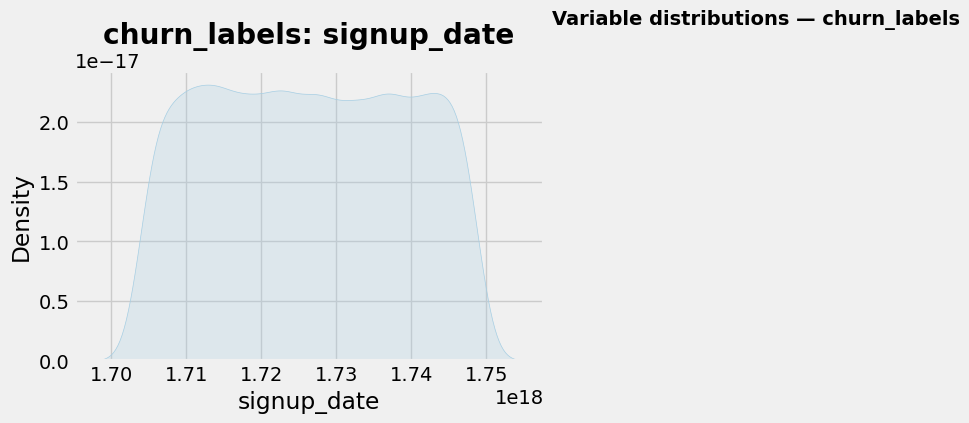

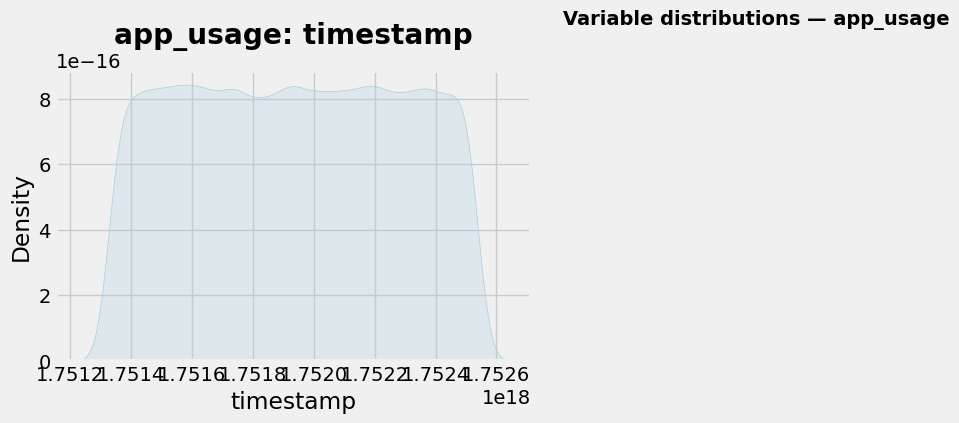

c:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


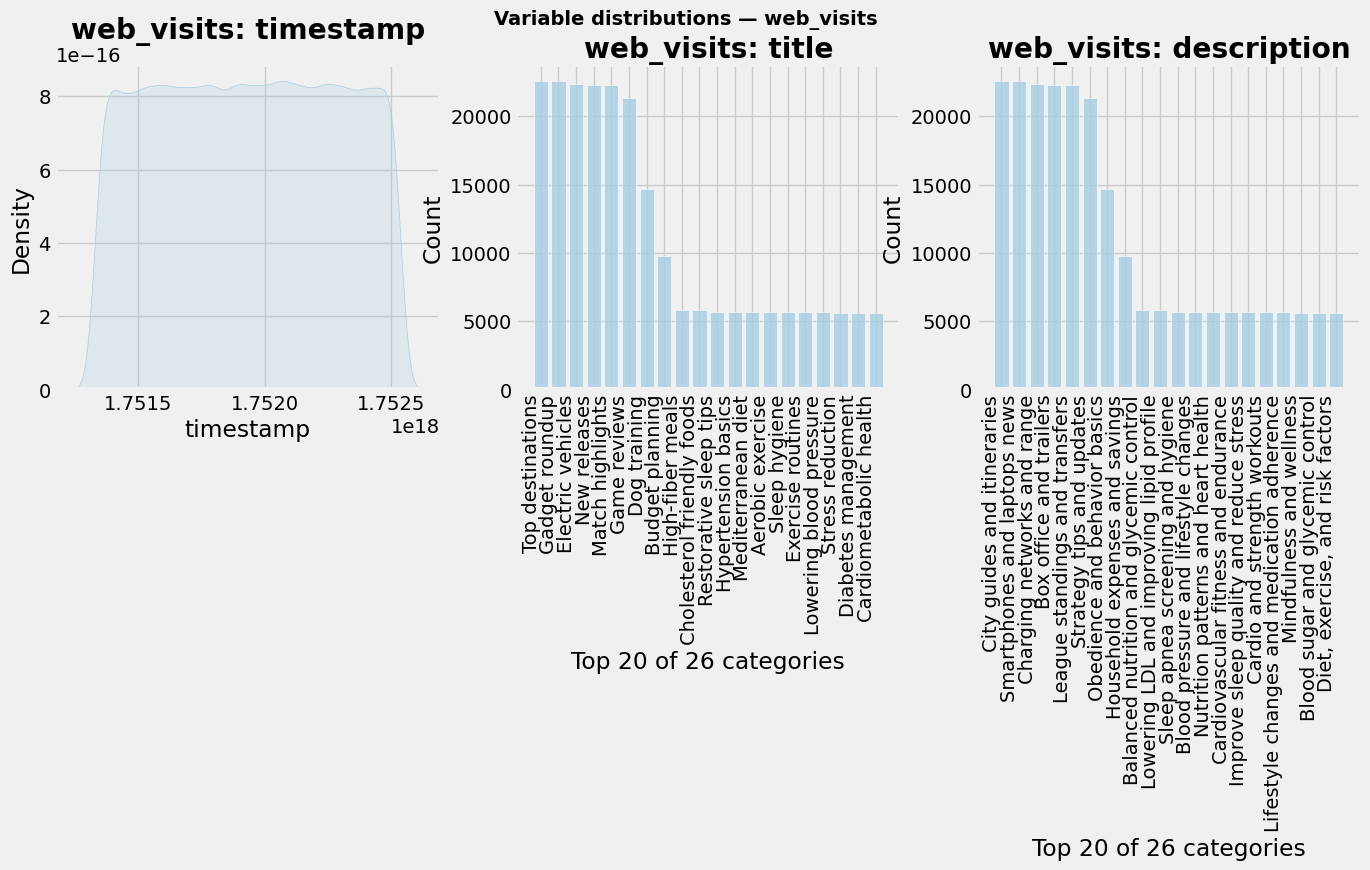

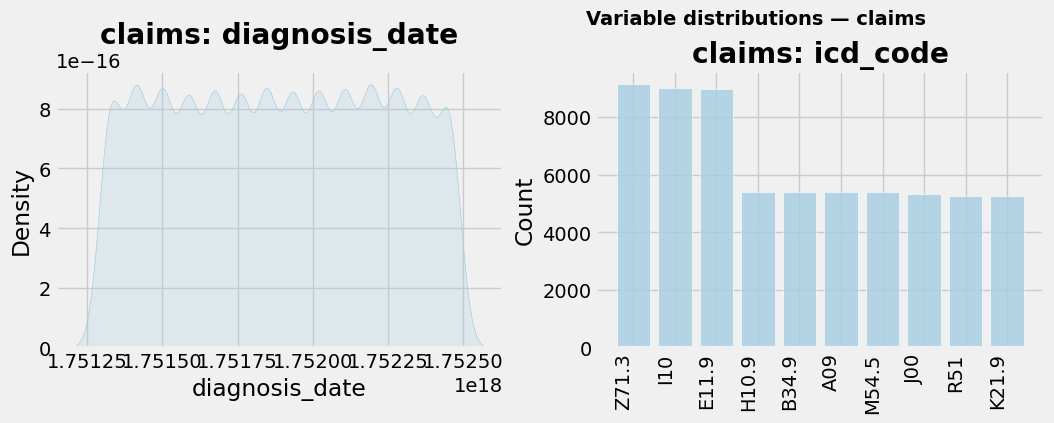

In [9]:
# 3.7 Variable distributions: KDE for numeric/datetime, bar for categorical (utils: plot_variable_distributions).
# Skip: member_id (id); churn, outreach (already in 3.5); event_type (constant in app_usage); url (too many levels, plot uninformative).
tables_for_dist = {
    "churn_labels": churn_labels,
    "app_usage": app_usage,
    "web_visits": web_visits,
    "claims": claims,
}
plot_variable_distributions(tables_for_dist, skip_cols={"member_id", "churn", "outreach", "event_type", "url"})

### 3.7 Table Aggregation

In [10]:
# 3.7 Per-member aggregates for EDA: all visits + WellCo-relevant web, app, claims, tenure (utils: build_member_aggregates).
WELLCO_BRIEF_PATH = FILE_DIR / 'wellco_client_brief.txt'
brief_text = load_wellco_brief(WELLCO_BRIEF_PATH)
embed_model = SentenceTransformer(EMBED_MODEL_NAME)
wellco_embedding = embed_wellco_brief(brief_text, embed_model)
member_agg = build_member_aggregates(churn_labels, app_usage, web_visits, claims, wellco_embedding=wellco_embedding, embed_model=embed_model)

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 714.73it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  embed_visit_texts: 26 unique texts embedded (from 259,340 rows)
Web relevance filter: 101,500 / 259,340 visits retained (threshold=0.2)


In [11]:
# Verify aggregation: one row per member, counts match raw tables, nulls where member absent from source.
_agg_log = BASE_DIR / ".cursor" / "debug.log"
_result = verify_member_aggregates(member_agg, churn_labels, app_usage, web_visits, claims, log_path=_agg_log)
print("Aggregation verification:", _result["message"])
print("Details:", _result["details"])

Aggregation verification: OK
Details: {'row_count_ok': True, 'app_ok': True, 'web_ok': True, 'claims_ok': True, 'app_match': True, 'app_zero_ok': True, 'web_match': True, 'web_zero_ok': True, 'claims_match': True, 'claims_zero_ok': True, 'n_members': 10000, 'n_app_rows': 97789, 'n_web_rows': 259340, 'n_claims_rows': 64576}


### 3.8 Variable distributions

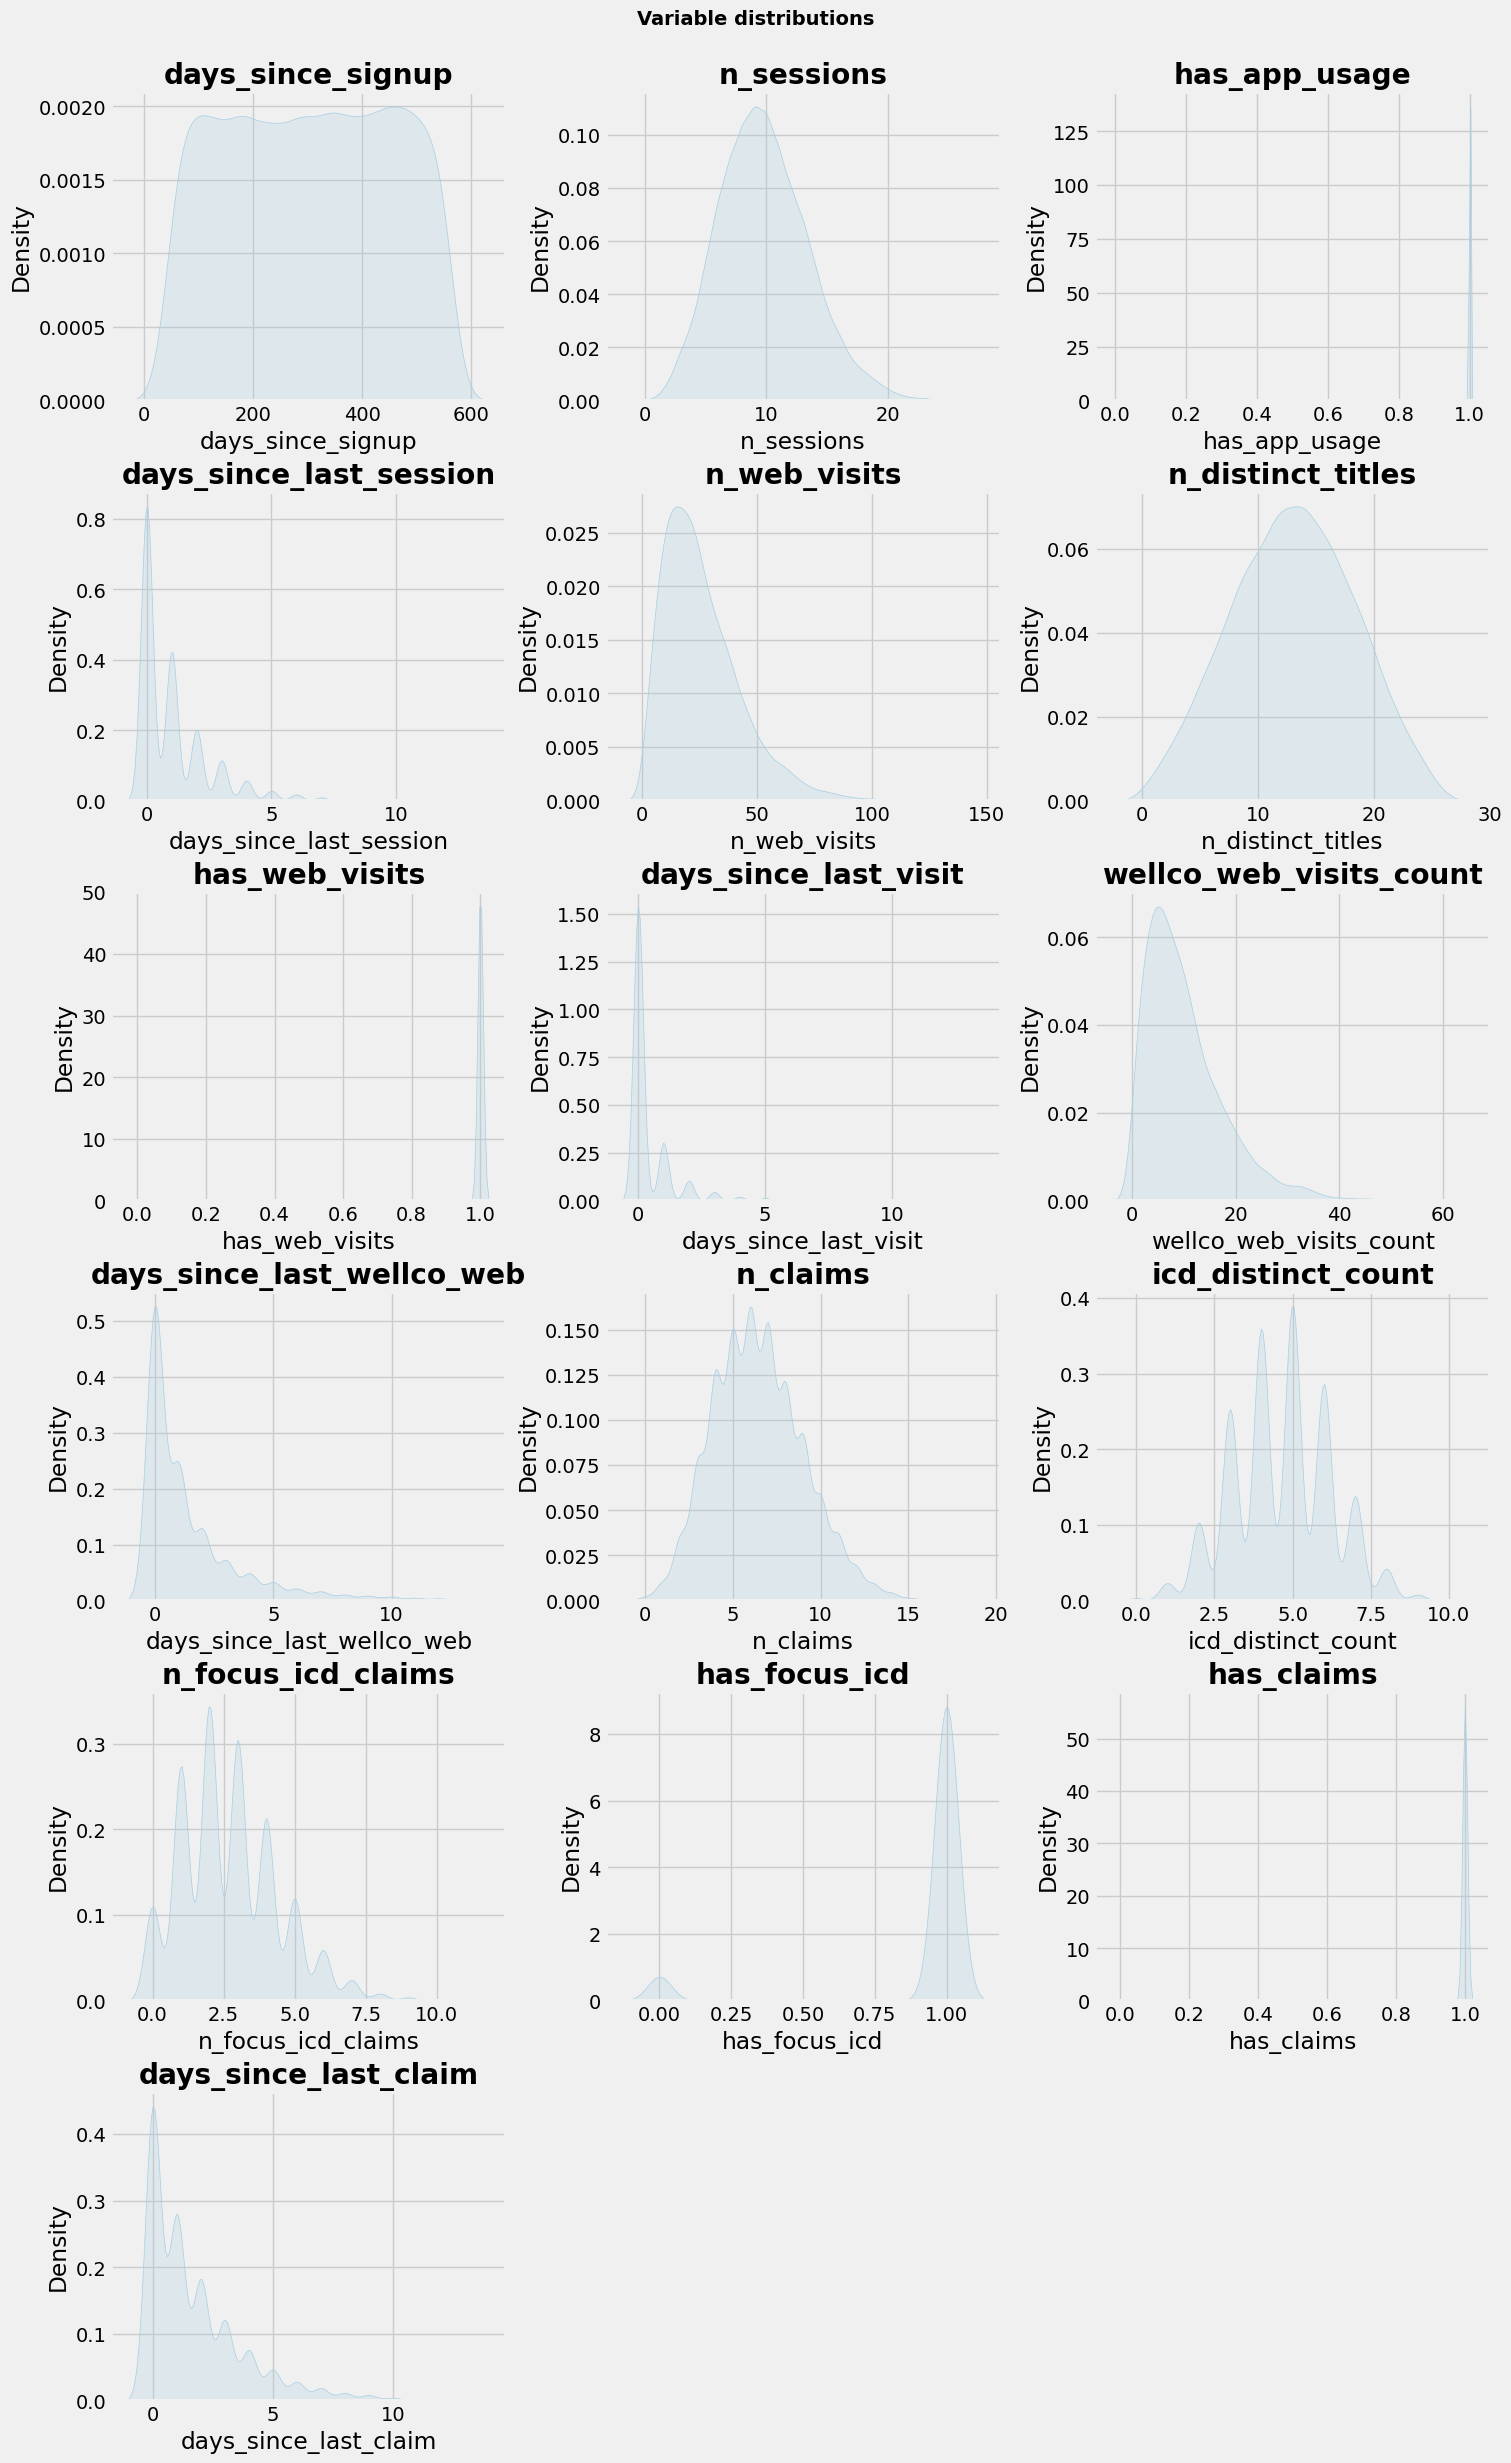

In [12]:
# Distributions of per-member variables: KDE for numeric, bar for categorical (same utils: plot_variable_distributions).
plot_variable_distributions({"member_agg": member_agg}, skip_cols={"member_id"}, omit_table_name_in_titles=True)

Per-member variable distributions: summary

What we see in each distribution

- **days_since_signup** — Spread from 0 to ~600 days, fairly uniform; mix of new and older members.
- **n_sessions** — Unimodal, peak around 8–10, mild right tail to ~20.
- **has_app_usage** — Almost all 1s; very low variance.
- **days_since_last_session** — Strong peak at 0 days, smaller bumps at 1–2 and ~5 days, then fast decay.
- **n_web_visits** — Right-skewed; mass at low counts, long tail to ~150.
- **n_distinct_titles** — Roughly bell-shaped, peak around 10–15.
- **has_web_visits** — Almost all 1s; very low variance.
- **days_since_last_visit** — Strong peak at 0 days, fast decay.
- **wellco_web_visits_count** — Zero-heavy (peak at 0), long right tail to ~60.
- **days_since_last_wellco_web** — Strong peak at 0 days among those with WellCo visits; fast decay.
- **n_claims** — Right-skewed, peak around 5–7, tail to ~20.
- **icd_distinct_count** — Multi-modal; peaks around 2, 4–5, 7–8.
- **n_focus_icd_claims** — Multi-modal; peaks near 1, 3, 5, 7–8.
- **has_focus_icd** — Mix of 0s and 1s; more balanced than other has_*.
- **has_claims** — Almost all 1s; very low variance.
- **days_since_last_claim** — Strong peak at 0 days, fast decay.

### 3.9 Null and missingness (per-member table)

After building the per-member aggregates (3.7–3.8), run the same style of checks as in 3.2–3.3: **null analysis** on the member aggregate table (column-level null counts), then **missingness mechanism** analysis (whether absence from activity sources correlates with churn/outreach) using the existing utils.

In [ ]:
# 3.9 Null analysis on per-member aggregates: all columns (null count + null %).
n_rows = len(member_agg)
null_rows = []
for col in member_agg.columns:
    cnt = member_agg[col].isnull().sum()
    pct = cnt / n_rows * 100 if n_rows else 0
    null_rows.append({
        "column": col,
        "null_count": int(cnt),
        "null_pct": round(pct, 2),
    })
null_df = pd.DataFrame(null_rows).sort_values("null_count", ascending=False).reset_index(drop=True)
print("=" * 70)
print("  Per-member table — All columns: null count and null %")
print("=" * 70)
print(null_df.to_string(index=False))

  Per-member table — All columns: null count and null %
                    column  null_count  null_pct
days_since_last_wellco_web         212      2.12
     days_since_last_visit          25      0.25
     days_since_last_claim          20      0.20
   days_since_last_session           2      0.02
                 member_id           0      0.00
             has_app_usage           0      0.00
              n_web_visits           0      0.00
                n_sessions           0      0.00
         days_since_signup           0      0.00
            has_web_visits           0      0.00
         n_distinct_titles           0      0.00
                  n_claims           0      0.00
   wellco_web_visits_count           0      0.00
        icd_distinct_count           0      0.00
        n_focus_icd_claims           0      0.00
             has_focus_icd           0      0.00
                has_claims           0      0.00


In [14]:
# 3.9 Missingness mechanism for the aggregated table (utils: missingness_mechanism_aggregated_table).
# Assign to _ so the returned DataFrame is not displayed again (function already prints the table).
_ = missingness_mechanism_aggregated_table(member_agg, churn_labels, alpha=0.05, print_result=True)

  Per-member table: missingness mechanism by column (null vs churn / outreach)
                    column  null_count churn_p outreach_p                  mechanism
days_since_last_wellco_web         212    0.25      0.398 MCAR (no sig. association)
     days_since_last_visit          25  0.2031     0.0633 MCAR (no sig. association)
     days_since_last_claim          20  0.4164        1.0 MCAR (no sig. association)
   days_since_last_session           2   0.866          — MCAR (no sig. association)
                 member_id           0       —          —                   no nulls
             has_app_usage           0       —          —                   no nulls
              n_web_visits           0       —          —                   no nulls
                n_sessions           0       —          —                   no nulls
         days_since_signup           0       —          —                   no nulls
            has_web_visits           0       —          —              

### 3.10 Multicollinearity

Correlation heatmap and flagged pairs (|r| ≥ threshold) on the per-member aggregate table. Use this to spot redundant variables before targeted bivariate vs target; high correlation suggests candidates to drop or consolidate.

Excluding constant columns (zero variance in complete-case subset): ['has_app_usage', 'has_web_visits', 'has_claims']


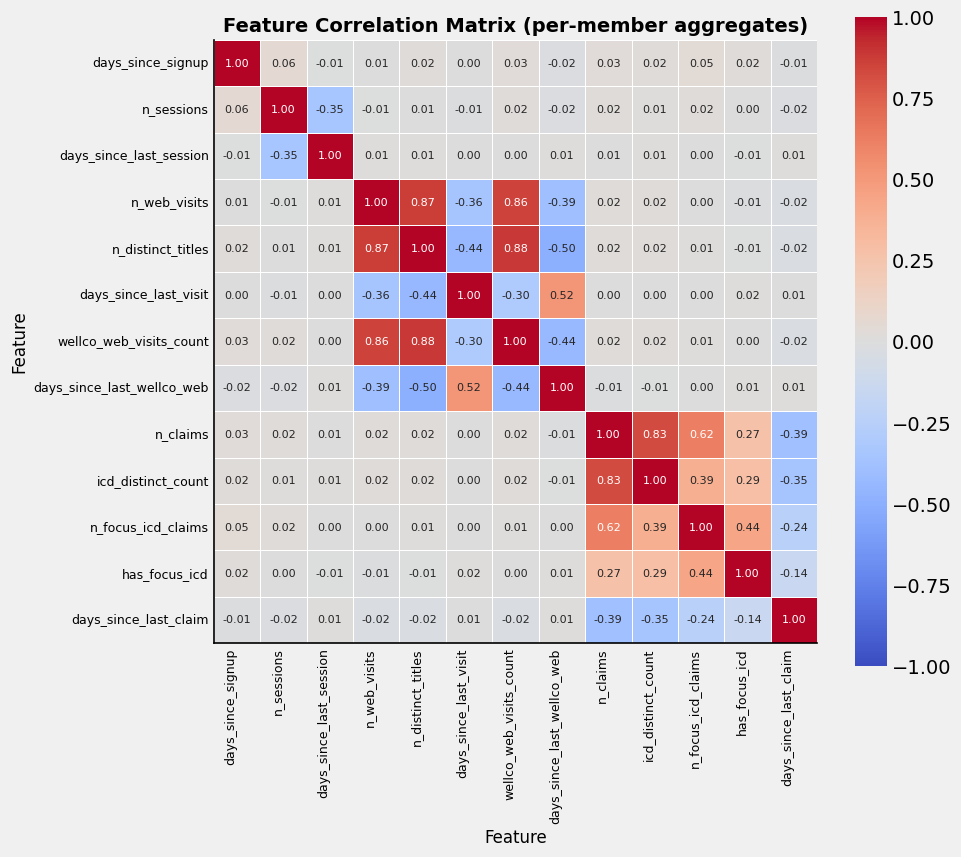


Pairs with |correlation| >= 0.8:
  n_web_visits  ↔  n_distinct_titles  :  r = 0.869
  n_web_visits  ↔  wellco_web_visits_count  :  r = 0.857
  n_distinct_titles  ↔  wellco_web_visits_count  :  r = 0.883
  n_claims  ↔  icd_distinct_count  :  r = 0.827


In [15]:
# 3.10 Multicollinearity (utils: plot_correlation_diagnostics). Feature cols = all per-member columns except member_id.
member_agg_feature_cols = [c for c in member_agg.columns if c != "member_id"]
plot_correlation_diagnostics(member_agg, member_agg_feature_cols, threshold=0.8, title_suffix="(per-member aggregates)")

Multicollinearity summary (redundant features)

From the correlation matrix (|r| ≥ 0.8):

- **Web group:** `n_web_visits`, `n_distinct_titles`, `wellco_web_visits_count` — all pairwise r ≈ 0.86–0.88. I'll be keeping one or two (e.g. `n_web_visits` and `wellco_web_visits_count`) and dropping `n_distinct_titles`.
- **Claims pair:** `n_claims` and `icd_distinct_count` — r = 0.83. I'll be keeping one (e.g. `n_claims`) and dropping the other.

### 3.11 Feature set for targeted bivariate (reduced)

The following will be dropped from the per-member feature set for the next steps (targeted bivariate vs target and any downstream use):

- **Multicollinearity (redundant):** `n_web_visits`, `n_distinct_titles`, `days_since_last_visit` — highly correlated with each other and with `wellco_web_visits_count`; I'll keep `wellco_web_visits_count` and `days_since_last_wellco_web` for web/WellCo signal. `icd_distinct_count` and `n_focus_icd_claims` — strongly correlated with `n_claims`; I'll keep `n_claims` and `has_focus_icd` for claims signal.
- **Low variance (almost constant):** `has_app_usage`, `has_web_visits`, `has_claims` — almost all 1s in the complete-case subset, so they add little discriminative signal.

The reduced list is used for targeted bivariate analysis vs churn (and optionally outreach), The purpose is to avoid redundant or non-informative variables.

In [16]:
# Dropped: multicollinearity (n_web_visits, n_distinct_titles, days_since_last_visit, icd_distinct_count, n_focus_icd_claims) and low variance (has_app_usage, has_web_visits, has_claims).
DROPPED_FEATURES = {
    "n_web_visits", "n_distinct_titles", "days_since_last_visit",
    "icd_distinct_count", "n_focus_icd_claims",
    "has_app_usage", "has_web_visits", "has_claims",
}
member_agg_feature_cols_reduced = [c for c in member_agg.columns if c != "member_id" and c not in DROPPED_FEATURES]
print("Reduced feature set for targeted bivariate:", member_agg_feature_cols_reduced)

Reduced feature set for targeted bivariate: ['days_since_signup', 'n_sessions', 'days_since_last_session', 'wellco_web_visits_count', 'days_since_last_wellco_web', 'n_claims', 'has_focus_icd', 'days_since_last_claim']


### 3.12 Targeted bivariate vs churn (per feature)

For each reduced feature: **left** — churn rate by decile of the feature (informs binning/threshold); **right** — box plot of feature by churn (separation/overlap).

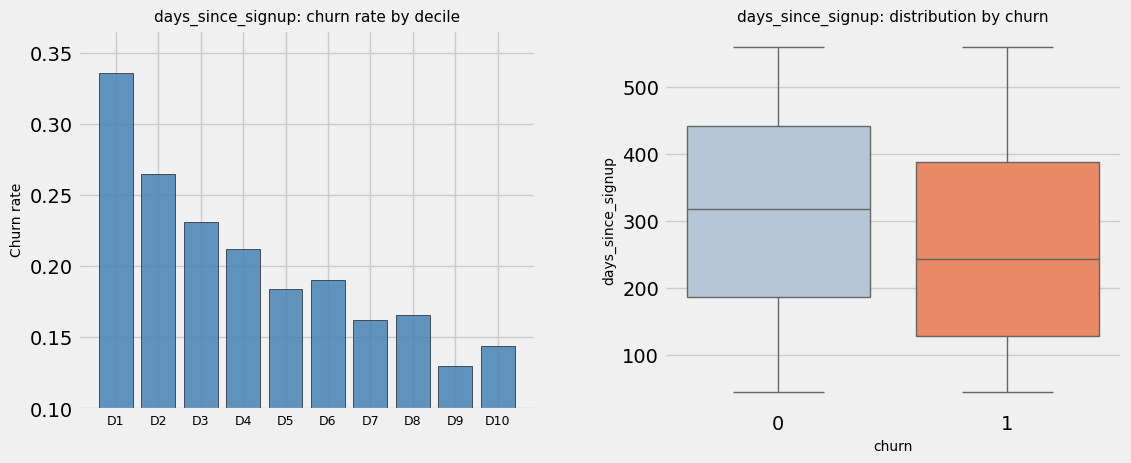

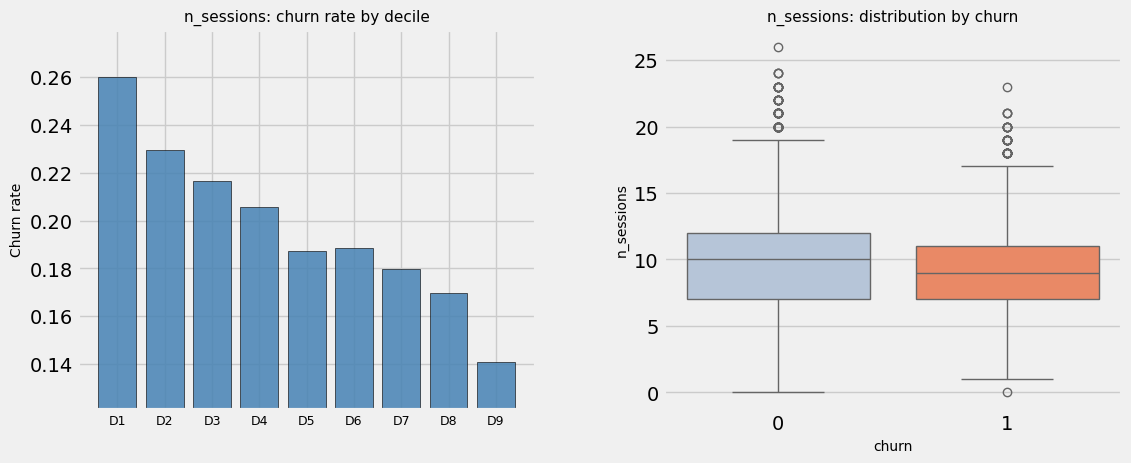

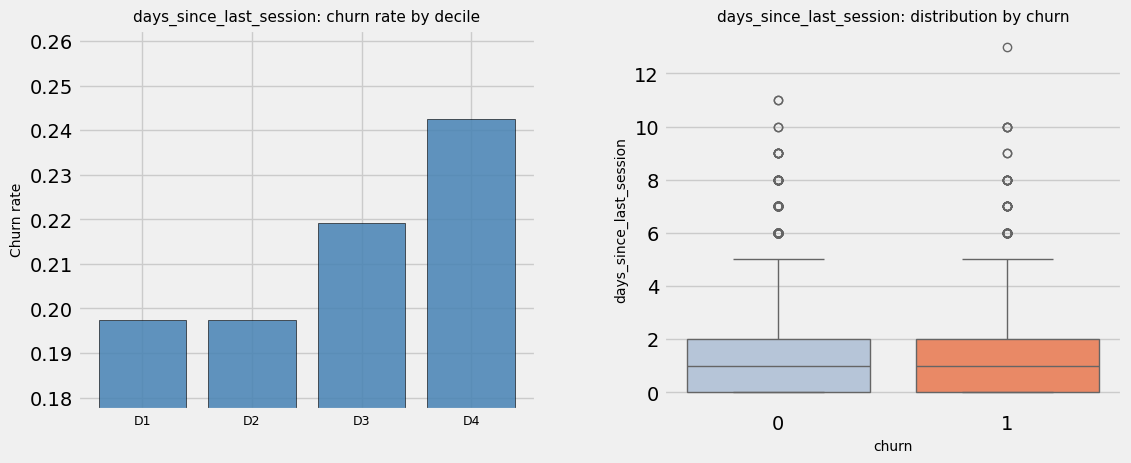

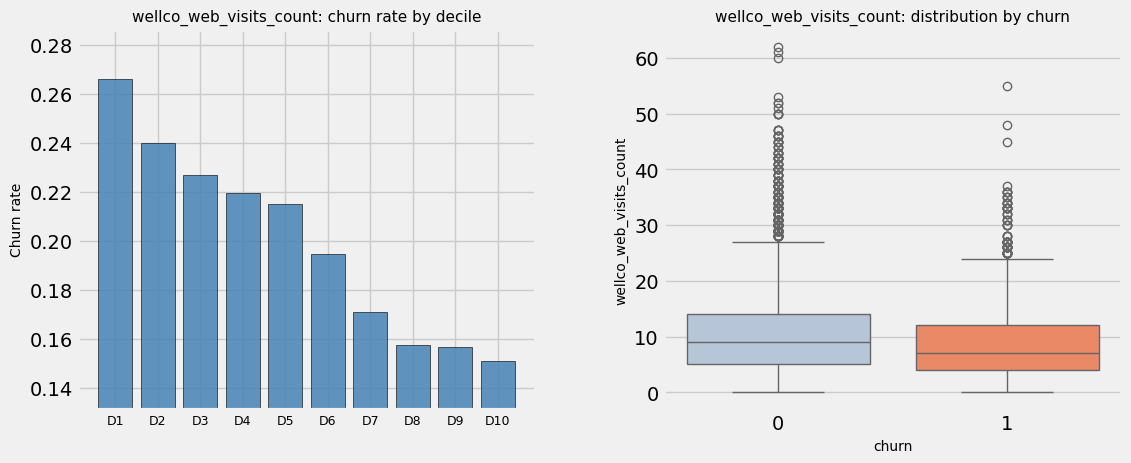

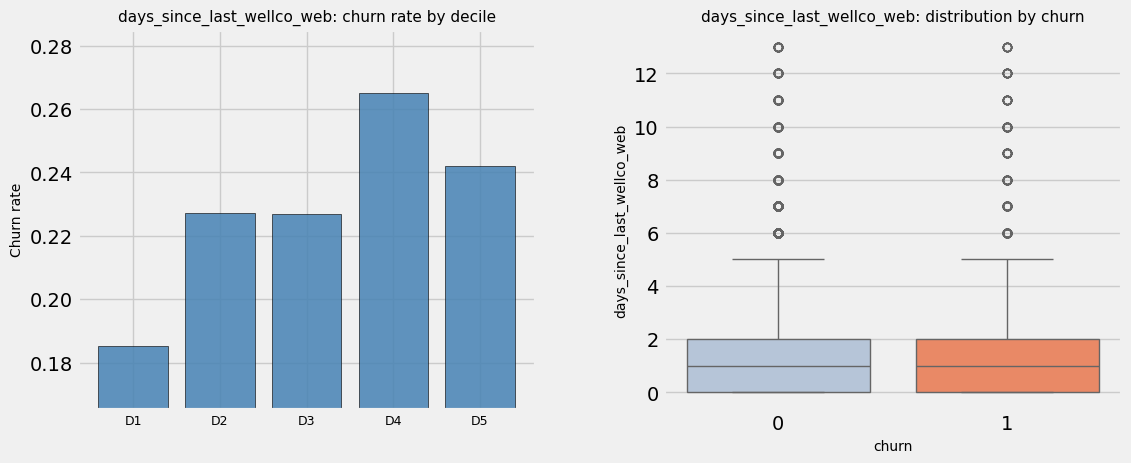

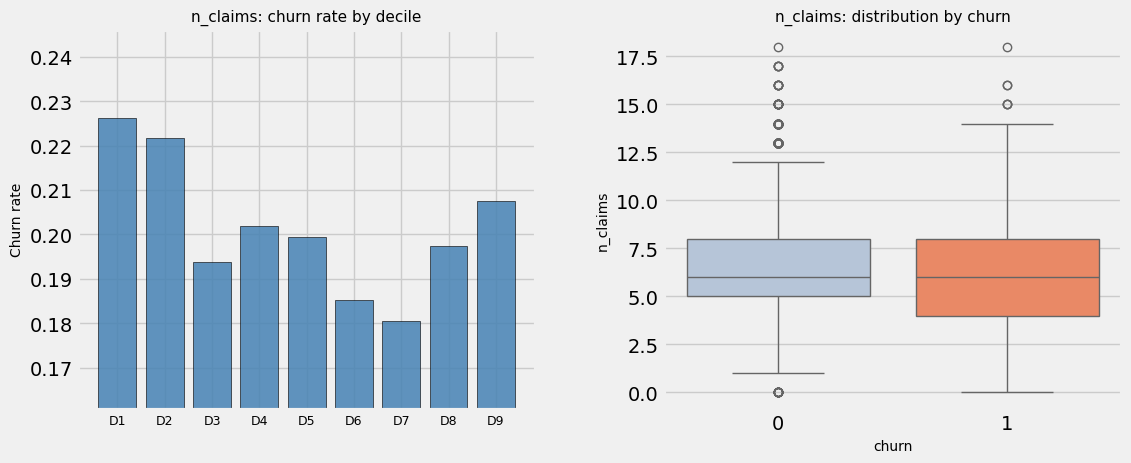

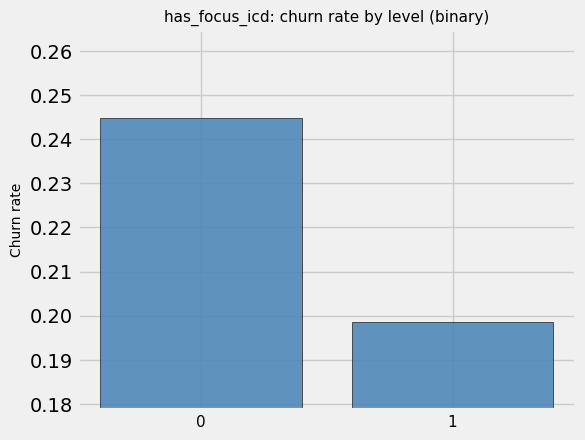

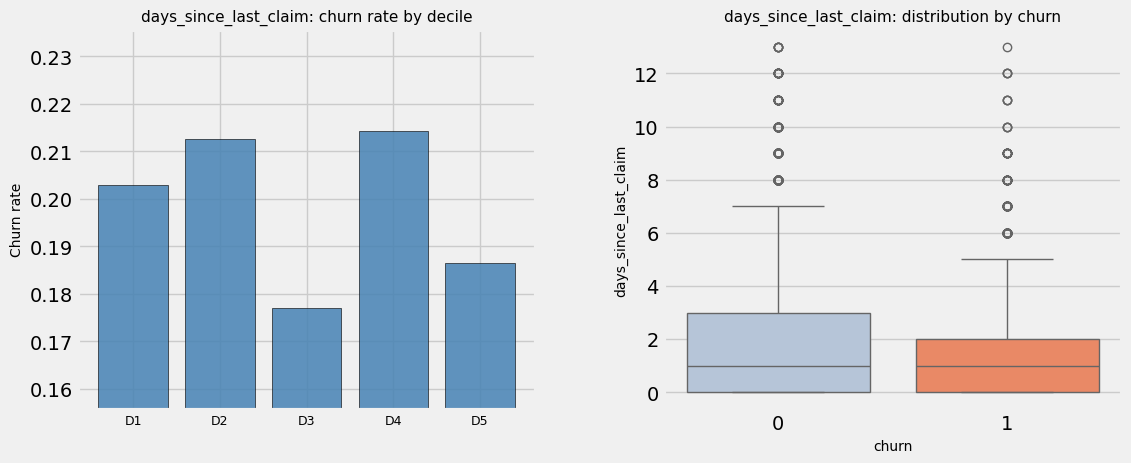

In [17]:
# 3.12 Bivariate vs churn: decile + box plot per feature (utils: plot_bivariate_churn_grid).
df_bivar = member_agg.merge(churn_labels[["member_id", "churn"]], on="member_id", how="inner")
plot_bivariate_churn_grid(df_bivar, member_agg_feature_cols_reduced, target_col="churn", n_deciles=10)

All preprocessing (scaling, transforms, binning) is **fit on training data only**; the same fitted parameters/boundaries are applied to validation and test to avoid leakage.

| Feature | Action | Details |
|---------|--------|---------|
| **days_since_signup** | Min-Max scaling | Preserves account age on [0,1]; "newness" as a stable predictor. |
| **n_sessions** | Standardization (Z-score) | Centers session volume for engagement signal. |
| **days_since_last_session** | Manual binning | **0** \| **1–7** \| **>7** → Active today \| Last week \| Lapsed. |
| **wellco_web_visits_count** | Log transform | `log(x+1)` to handle zero-heavy and long tail. |
| **days_since_last_wellco_web** | Manual binning | **0** \| **1–7** \| **>7** → Active today \| Last week \| Stale. |
| **n_claims** | Min-Max scaling | Keeps count granularity on a [0,1] scale. |
| **has_focus_icd** | Keep as-is | Binary {0, 1}; no scaling or binning. |
| **days_since_last_claim** | Manual binning | **0** \| **1–7** \| **>7** → Claim today \| Last week \| Lapsed. |

**Manual binning (recency):** For `days_since_last_session`, `days_since_last_wellco_web`, and `days_since_last_claim`, boundaries are chosen from the **training** distribution (0 vs 1–7 vs >7 days). The same boundaries are applied to validation/test. Recency columns can be encoded as ordered categories or dummy variables for modeling.

**Implementation note:** Scaling and log transforms are applied to all continuous features for a consistent pipeline; tree-based models do not require scaling, but using it everywhere keeps preprocessing uniform and supports adding linear or distance-based models later.

### 4. Feature Engineering

In [ ]:
# 4. Feature Engineering — three steps: filter train, aggregate test (same process as train), run engineering on each.

OUT_DIR = FILE_DIR / "engineered"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Step 1: Train aggregated table already built; keep only member_id + 8 features.
train_agg = member_agg[["member_id"] + MEMBER_AGG_FEATURE_COLS].copy()

# Step 2: Build test aggregates the same way as train (ref_date, WellCo embedding + model) to get the same 8 features.
ref_date = ref_date_from_tables(web_visits, app_usage, claims)
test_member_agg = build_member_aggregates(
    test_members, test_app_usage, test_web_visits, test_claims,
    ref_date=ref_date, wellco_embedding=wellco_embedding, embed_model=embed_model,
)
test_agg = test_member_agg[["member_id"] + MEMBER_AGG_FEATURE_COLS].copy()

# Step 3: Run feature engineering on each dataset (train: no reference; test: reference=train for scaling).
train_engineered = engineer_member_aggregates(train_agg, reference_agg=None, out_path=None)
test_engineered = engineer_member_aggregates(test_agg, reference_agg=train_agg, out_path=OUT_DIR / "test_engineered.csv")

# Attach labels for train and save as the single train output (member_id for indexing only; not a model feature).
train_final = train_engineered.merge(churn_labels[["member_id", "churn", "outreach"]], on="member_id", how="left")
train_final.to_csv(OUT_DIR / "train_engineered.csv", index=False)
print("Train shape:", train_final.shape, "| Test shape:", test_engineered.shape)

  embed_visit_texts: 26 unique texts embedded (from 261,729 rows)
Web relevance filter: 102,187 / 261,729 visits retained (threshold=0.2)
Train shape: (10000, 17) | Test shape: (10000, 15)


In [25]:
# Two engineered outputs: train_engineered.csv (train + labels), test_engineered.csv (test).
list(OUT_DIR.iterdir())

[WindowsPath('C:/Users/gilad/CursorProjects/uplifting_modeling_fixed/Uplift-Modeling-Churn-Prevention/files/engineered/test_engineered.csv'),
 WindowsPath('C:/Users/gilad/CursorProjects/uplifting_modeling_fixed/Uplift-Modeling-Churn-Prevention/files/engineered/train_engineered.csv')]